# CSCN8020 – Assignment 3  
## Deep Q-Learning on Atari Pong (TensorFlow Version)

**Student Name:** Haysam Elamin  
**Student ID:** 8953681  

---

### Assignment Context

This notebook implements a **Deep Q-Network (DQN)** agent to play **Atari Pong** using:

- **Gymnasium** (newer Gym API)  
- **TensorFlow / Keras** (CPU-friendly, no PyTorch DLL issues)  


---

### Notebook Structure

1. Environment & Library Setup  
2. Pong Environment Overview  
3. Frame Preprocessing (Cropping, Downsampling, Grayscale, Normalization)  
4. DQN Agent (TensorFlow/Keras) – Model & Replay Buffer  
5. Training Utilities  
6. **Experiment 1** – Baseline DQN  
7. **Experiment 2** – Small Batch, Frequent Target Updates  
8. **Experiment 3** – Large Batch, Slow Target Updates  
9. Results Summary & Reflections  
10. Link to Exploration–Exploitation in Bandits  




In [16]:
"""
Cell 2  Imports & Global Configuration

This cell:
- Imports all required libraries.
- Sets some global constants and random seeds.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gymnasium as gym  # Modern Gym API
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make plots appear inline in Jupyter
%matplotlib inline

# For (semi-)reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Global image shape after preprocessing Pong frames
IMAGE_SHAPE = (80, 80)   # (height, width)

# Directory where we could save models / logs if needed
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


## 2. Pong Environment Overview

We use the **`ALE/Pong-v5`** environment from **Gymnasium**:

- **Observation:** RGB image frames of size `(210, 160, 3)`.
- **Action Space:** `Discrete(n)` actions (e.g., NOOP, move up, move down, etc.).

New Gymnasium API:

- `obs, info = env.reset()`
- `obs, reward, terminated, truncated, info = env.step(action)`
- Episode is done when `terminated or truncated` is `True`.

We will:
- Create the environment.
- Print the observation and action space.
- Use it later inside our training loop.


In [17]:
"""
Cell 4 - Create & Inspect Pong Environment

If Atari / ALE is not installed, this cell will show a clear error message.
"""

try:
    # Note: Requires: pip install "gymnasium[atari,accept-rom-license]"
    env = gym.make("ALE/Pong-v5", render_mode=None)
    obs, info = env.reset()
    
    print("Environment created successfully.")
    print("Raw observation shape:", obs.shape)
    print("Action space:", env.action_space)
except Exception as e:
    print("❌ Error creating ALE/Pong-v5 environment.")
    print("   Make sure you installed Atari support with:")
    print('   pip install "gymnasium[atari,accept-rom-license]"')
    print("Exception message:", e)
    env = None  # Ensure env is defined but set to None


Environment created successfully.
Raw observation shape: (210, 160, 3)
Action space: Discrete(6)


## 3. Frame Preprocessing

Raw Pong frames are:

- Large (210×160×3)
- Include score, borders, HUD, etc.

To make learning more efficient, we apply a standard preprocessing pipeline:

1. **Crop**: Remove top and bottom HUD / borders.  
2. **Downsample**: Take every 2nd pixel in height and width.  
3. **Grayscale**: Average RGB channels → single channel.  
4. **Normalize**: Map pixel values to approximately `[-1, 1]`.  
5. **Reshape**: Shape to `(1, H, W, 1)` for input into our CNN.

The function `process_frame(img, image_shape)` below implements all these steps.
"""


In [18]:
"""
Cell 6 - Frame Preprocessing Utilities

This includes:
- img_crop: Pong-specific cropping.
- downsample: Reduce resolution by factor 2.
- to_grayscale: Convert RGB to grayscale.
- normalize_grayscale: Normalize to approx. [-1, 1].
- process_frame: Full pipeline producing a (1, H, W, 1) tensor.
"""

def img_crop(img):
    """
    Crop the top and bottom parts of the Pong frame.
    This removes borders and HUD, focusing on the game area.
    """
    return img[30:-12, :, :]  # slice rows; keep all columns and channels


def downsample(img):
    """
    Downsample the image by a factor of 2 in both height and width.
    This reduces computational cost and memory.
    """
    return img[::2, ::2, :]  # take every 2nd pixel in both axes


def to_grayscale(img):
    """
    Convert an RGB image to grayscale by averaging color channels.
    Returns a 2D array (H, W) of uint8 values.
    """
    gray = np.mean(img, axis=2).astype(np.uint8)
    return gray


def normalize_grayscale(img):
    """
    Normalize grayscale pixel values to approximately [-1, 1].
    
    Starting with values in [0, 255]:
    - Subtract 128 to center around 0.
    - Divide by 128 to scale.
    - Subtract 1 to shift into [-1, ~1].
    """
    return (img - 128) / 128.0 - 1.0


def process_frame(img, image_shape):
    """
    Full preprocessing pipeline:
    1. Crop (Pong-specific)
    2. Downsample
    3. Grayscale
    4. Normalize
    5. Reshape to (1, H, W, 1) for CNN input
    
    Parameters
    ----------
    img : np.ndarray
        Raw frame from the environment (210x160x3).
    image_shape : tuple
        Desired (height, width) of output.

    Returns
    -------
    np.ndarray
        Processed frame with shape (1, H, W, 1) as float32.
    """
    # 1. Crop the image
    img = img_crop(img)
    
    # 2. Downsample by factor of 2
    img = downsample(img)
    
    # 3. Convert to grayscale
    img = to_grayscale(img)
    
    # 4. Normalize to [-1, 1]
    img = normalize_grayscale(img)
    
    # 5. Resize / reshape to desired image_shape (simple center crop or pad)
     
    h, w = image_shape
    img = img[:h, :w]  # simple top-left crop to (h, w) if slightly larger
    
    # Add channel dimension and batch dimension: (1, H, W, 1)
    img = img.reshape((1, h, w, 1)).astype(np.float32)
    
    return img


def transform_reward(reward):
    """
    
    - Many DQN Pong implementations use sign(reward) to stabilize learning.
    - This maps all positive rewards to +1, negative to -1, and zero stays 0.
    """
    return np.sign(reward)


Raw observation shape: (210, 160, 3)
Processed frame shape: (1, 80, 80, 1)


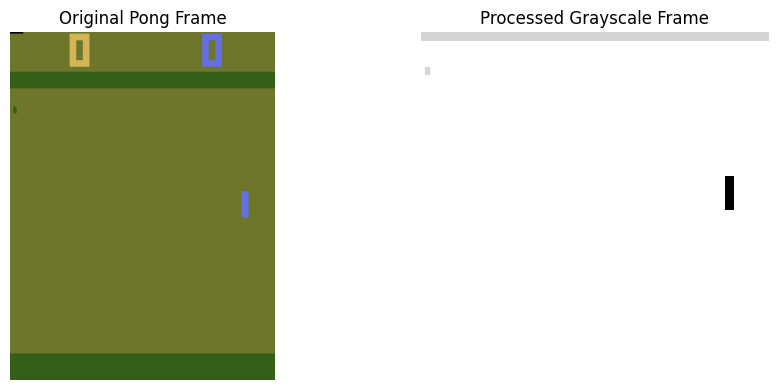

In [19]:
"""
Cell 7 - Test Preprocessing

This cell:
- Takes one observation from the environment.
- Applies process_frame.
- Plots original vs processed grayscale image.

If env is None (Atari not installed), it will skip gracefully.
"""

if env is not None:
    obs, info = env.reset()
    processed = process_frame(obs, IMAGE_SHAPE)
    
    print("Raw observation shape:", obs.shape)
    print("Processed frame shape:", processed.shape)
    
    # Plot original vs processed
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Pong Frame")
    plt.imshow(obs)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Processed Grayscale Frame")
    plt.imshow(processed[0, :, :, 0], cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping preprocessing visualization because env could not be created.")


## 4. DQN Agent – TensorFlow/Keras

We implement a **Deep Q-Network (DQN)** with:

- **CNN feature extractor** for Pong frames.
- **Fully connected layers** to output Q-values for each action.
- **Experience Replay Buffer** to break correlations between consecutive steps.
- **Target Network** to stabilize learning.
- **ε-greedy policy** for exploration–exploitation trade-off.

Key hyperparameters:

- `gamma`: Discount factor for future rewards.  
- `batch_size`: Number of transitions per training step.  
- `buffer_capacity`: Replay buffer size.  
- `min_replay_size`: Minimum experiences before we start learning.  
- `epsilon_start`, `epsilon_end`, `epsilon_decay_frames`: ε schedule.  
- `target_update_freq`: How often to sync the target network with the online network.  

We will vary **batch_size** and **target_update_freq** across experiments.


In [20]:
"""
Cell 9 - DQNAgent Implementation (TensorFlow / Keras)

This class encapsulates:
- Online & target networks
- Replay buffer
- Epsilon-greedy policy
- Single training step logic
"""

class DQNAgent:
    def __init__(
        self,
        state_shape,
        num_actions,
        gamma=0.99,
        buffer_capacity=100_000,
        batch_size=32,
        min_replay_size=10_000,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay_frames=1_000_000,
        target_update_freq=10_000,
        learning_rate=1e-4,
    ):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.gamma = gamma
        
        # Replay buffer (simple Python list of tuples)
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.min_replay_size = min_replay_size
        self.replay_buffer = []
        
        # Epsilon-greedy parameters
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_frames = epsilon_decay_frames
        self.epsilon = epsilon_start
        self.total_frames = 0  # counts training frames for epsilon decay
        
        # Target network update frequency (in gradient steps)
        self.target_update_freq = target_update_freq
        self.train_steps = 0
        
        # Build networks
        self.online_network = self._build_model(learning_rate)
        self.target_network = self._build_model(learning_rate)
        self._update_target_network()  # make sure target starts equal to online

    def _build_model(self, learning_rate):
        """
        Build a CNN-based Q-network using Keras.
        Input:  (H, W, 1) preprocessed frame
        Output: Q-values for each action
        """
        inputs = keras.Input(shape=self.state_shape)
        
        # Convolutional layers similar to classic DQN (simplified)
        x = layers.Conv2D(32, (8, 8), strides=4, activation="relu")(inputs)
        x = layers.Conv2D(64, (4, 4), strides=2, activation="relu")(x)
        x = layers.Conv2D(64, (3, 3), strides=1, activation="relu")(x)
        x = layers.Flatten()(x)
        
        x = layers.Dense(512, activation="relu")(x)
        outputs = layers.Dense(self.num_actions, activation=None)(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="mse"
        )
        return model

    def _update_target_network(self):
   
        self.target_network.set_weights(self.online_network.get_weights())

    def store_transition(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer.
        If the buffer is full, remove the oldest transition (FIFO).
        """
        if len(self.replay_buffer) >= self.buffer_capacity:
            self.replay_buffer.pop(0)  # remove oldest
        
        self.replay_buffer.append((state, action, reward, next_state, done))

    def _sample_batch(self):
        """
        Randomly sample a batch of transitions from the replay buffer.
        Returns arrays for states, actions, rewards, next_states, dones.
        """
        idxs = np.random.choice(len(self.replay_buffer), size=self.batch_size, replace=False)
        batch = [self.replay_buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Concatenate along batch dimension
        states = np.concatenate(states, axis=0)
        next_states = np.concatenate(next_states, axis=0)
        actions = np.array(actions, dtype=np.int32)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)
        
        return states, actions, rewards, next_states, dones

    def select_action(self, state):
        """
        Epsilon-greedy action selection for training.
        With probability epsilon: random action (explore)
        Otherwise: argmax_a Q_online(state, a) (exploit)
        """
        self.total_frames += 1
        
        # Linearly decay epsilon
        frac = min(1.0, self.total_frames / self.epsilon_decay_frames)
        self.epsilon = self.epsilon_start + frac * (self.epsilon_end - self.epsilon_start)
        
        if np.random.rand() < self.epsilon:
            # Explore
            return np.random.randint(self.num_actions)
        else:
            # Exploit (greedy)
            q_values = self.online_network.predict(state, verbose=0)
            return int(np.argmax(q_values[0]))

    def select_greedy_action(self, state):
        """
        Greedy action selection without exploration (epsilon=0).
        Useful for evaluation after training.
        """
        q_values = self.online_network.predict(state, verbose=0)
        return int(np.argmax(q_values[0]))

    def train_step(self):
        """
        Perform a single gradient update using a sampled batch from the replay buffer.
        
        Returns:
            loss (float) or None if not enough data yet.
        """
        # Only update if we have enough data
        if len(self.replay_buffer) < self.min_replay_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self._sample_batch()
        
        # Q(s, a) from online network
        q_values = self.online_network.predict(states, verbose=0)
        
        # Q'(s', a') from target network
        next_q_values = self.target_network.predict(next_states, verbose=0)
        max_next_q = np.max(next_q_values, axis=1)
        
        # Compute target: r + gamma * max_a' Q'(s', a')  (0 if done)
        targets = q_values.copy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * max_next_q[i]
        
        # Train online network on (states, targets)
        history = self.online_network.fit(states, targets, epochs=1, verbose=0)
        loss = history.history["loss"][0]
        
        # Count training steps for target network update
        self.train_steps += 1
        if self.train_steps % self.target_update_freq == 0:
            self._update_target_network()
        
        return loss


## 5. Training Utilities

Helper function `run_experiment(config)` that:

- Accepts hyperparameters (episodes, batch_size, target_update_freq, etc.).
- Creates a new `DQNAgent` with those hyperparameters.
- Runs training for a given number of episodes.
- Logs:
  - Episode total reward  
  - Mean loss per episode  
- Returns a dictionary containing history and summary statistics.

We will use this function for **Experiment 1, 2, and 3**.


In [21]:
"""
Cell 11  Training Utility Function

run_experiment(config):
- Creates fresh environment + agent.
- Trains for config["num_episodes"] episodes.
- Uses global IMAGE_SHAPE.
"""

def run_experiment(exp_id, config):
    """
    Run one DQN training experiment with given hyperparameters.

    Parameters
    ----------
    exp_id : int
        Experiment identifier (1, 2, or 3).
    config : dict
        Dictionary with keys:
        - num_episodes
        - max_steps_per_episode
        - batch_size
        - target_update_freq
        - gamma
        - buffer_capacity
        - min_replay_size
        - epsilon_start
        - epsilon_end
        - epsilon_decay_frames
        - learning_rate

    Returns
    -------
    result : dict
        Contains episode_rewards, losses, final_epsilon, and summary stats.
    """
    print(f"\n🔁 Starting Experiment {exp_id} with config:")
    for k, v in config.items():
        print(f"   {k}: {v}")

    # Re-create environment for a clean run
    env_local = gym.make("ALE/Pong-v5", render_mode=None)
    obs, info = env_local.reset()

    # Define state shape and actions
    state_shape = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
    num_actions = env_local.action_space.n

    # Create DQN agent with given hyperparameters
    agent = DQNAgent(
        state_shape=state_shape,
        num_actions=num_actions,
        gamma=config["gamma"],
        buffer_capacity=config["buffer_capacity"],
        batch_size=config["batch_size"],
        min_replay_size=config["min_replay_size"],
        epsilon_start=config["epsilon_start"],
        epsilon_end=config["epsilon_end"],
        epsilon_decay_frames=config["epsilon_decay_frames"],
        target_update_freq=config["target_update_freq"],
        learning_rate=config["learning_rate"],
    )

    episode_rewards = []
    episode_losses = []

    # Main training loop
    for episode in range(1, config["num_episodes"] + 1):
        obs, info = env_local.reset()
        state = process_frame(obs, IMAGE_SHAPE)
        
        total_reward = 0.0
        losses = []

        for step in range(config["max_steps_per_episode"]):
            # 1. Select action via epsilon-greedy
            action = agent.select_action(state)

            # 2. Step the environment
            next_obs, reward, terminated, truncated, info = env_local.step(action)
            done = terminated or truncated

            # 3. Transform reward
            reward = transform_reward(reward)

            # 4. Preprocess next state
            next_state = process_frame(next_obs, IMAGE_SHAPE)

            # 5. Store transition in replay buffer
            agent.store_transition(state, action, reward, next_state, done)

            # 6. Training step
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)

            state = next_state
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)
        mean_loss = np.mean(losses) if losses else np.nan
        episode_losses.append(mean_loss)

        print(
            f"Exp {exp_id} | Episode {episode}/{config['num_episodes']} "
            f"| Total Reward: {total_reward:.2f} "
            f"| Mean Loss: {mean_loss:.4f} "
            f"| Epsilon: {agent.epsilon:.3f} "
            f"| Buffer Size: {len(agent.replay_buffer)}"
        )

    env_local.close()

    # Summary statistics
    avg_reward = np.mean(episode_rewards)
    last_5_avg = np.mean(episode_rewards[-5:]) if len(episode_rewards) >= 5 else avg_reward

    result = {
        "exp_id": exp_id,
        "config": config,
        "episode_rewards": episode_rewards,
        "episode_losses": episode_losses,
        "avg_reward": avg_reward,
        "last_5_avg_reward": last_5_avg,
        "final_epsilon": agent.epsilon,
    }
    return result


## 6–8. Experiments 1, 2, and 3

We will run **three experiments** with different values of:

- `batch_size`  
- `target_update_freq`  

All other hyperparameters are kept constant, so we can isolate the effect of these two.

### ✅ Experiment 1 – Baseline

- `batch_size = 32`  
- `target_update_freq = 10_000`  

### ✅ Experiment 2 – Smaller Batch, More Frequent Target Updates

- `batch_size = 16`  
- `target_update_freq = 2_000`  

### ✅ Experiment 3 – Larger Batch, Less Frequent Target Updates

- `batch_size = 64`  
- `target_update_freq = 20_000`  




In [ ]:
"""
Cell 13 - Run Experiments 1, 2, 3

This cell defines three configurations and runs them.
"""

# Common hyperparameters for all experiments
COMMON_CONFIG = {
    "num_episodes": 20,            # small for demonstration
    "max_steps_per_episode": 500,
    "gamma": 0.99,
    "buffer_capacity": 50_000,
    "min_replay_size": 1_000,     # start learning after 1000 transitions
    "epsilon_start": 1.0,
    "epsilon_end": 0.1,
    "epsilon_decay_frames": 50_000,
    "learning_rate": 1e-4,
}

# Experiment 1 – Baseline
config_exp1 = COMMON_CONFIG.copy()
config_exp1.update({
    "batch_size": 32,
    "target_update_freq": 10_000,
})

# Experiment 2 – Small batch, frequent target updates
config_exp2 = COMMON_CONFIG.copy()
config_exp2.update({
    "batch_size": 16,
    "target_update_freq": 2_000,
})

# Experiment 3 – Large batch, slow target updates
config_exp3 = COMMON_CONFIG.copy()
config_exp3.update({
    "batch_size": 64,
    "target_update_freq": 20_000,
})

# Run all experiments
results_exp1 = run_experiment(exp_id=1, config=config_exp1)
results_exp2 = run_experiment(exp_id=2, config=config_exp2)
results_exp3 = run_experiment(exp_id=3, config=config_exp3)



🔁 Starting Experiment 1 with config:
   num_episodes: 20
   max_steps_per_episode: 500
   gamma: 0.99
   buffer_capacity: 50000
   min_replay_size: 1000
   epsilon_start: 1.0
   epsilon_end: 0.1
   epsilon_decay_frames: 50000
   learning_rate: 0.0001
   batch_size: 32
   target_update_freq: 10000
Exp 1 | Episode 1/20 | Total Reward: -11.00 | Mean Loss: nan | Epsilon: 0.991 | Buffer Size: 500
Exp 1 | Episode 2/20 | Total Reward: -12.00 | Mean Loss: 0.0057 | Epsilon: 0.982 | Buffer Size: 1000
Exp 1 | Episode 3/20 | Total Reward: -8.00 | Mean Loss: 0.0034 | Epsilon: 0.973 | Buffer Size: 1500


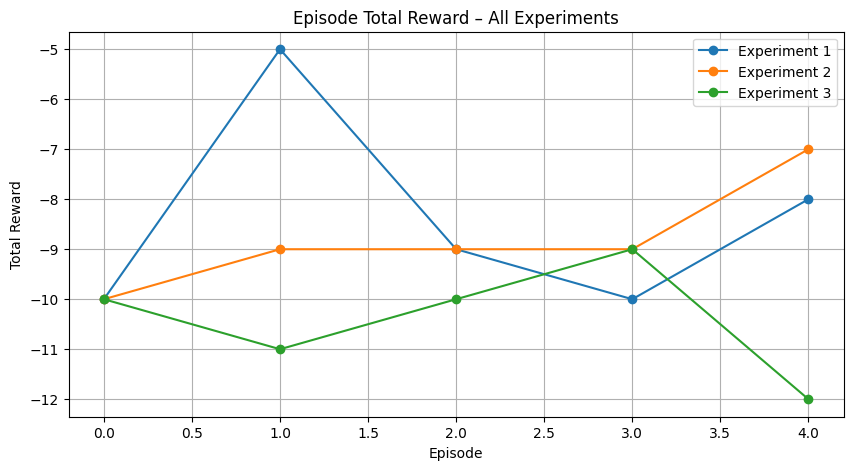

In [ ]:
"""
Cell 14  Plot Episode Rewards for Each Experiment

We compare learning curves across experiments.
"""

def plot_rewards(results, title_prefix="Experiment"):
    episode_rewards = results["episode_rewards"]
    exp_id = results["exp_id"]
    
    plt.plot(episode_rewards, marker='o', label=f"{title_prefix} {exp_id}")

plt.figure(figsize=(10, 5))
plot_rewards(results_exp1)
plot_rewards(results_exp2)
plot_rewards(results_exp3)
plt.title("Episode Total Reward – All Experiments")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
"""
Cell 15  Build Summary Table of Experiment Results

Shows:
- Batch size
- Target update frequency
- Average total reward
- Last 5 episodes average reward
- Final epsilon
"""

summary_rows = []

for res in [results_exp1, results_exp2, results_exp3]:
    cfg = res["config"]
    summary_rows.append({
        "Experiment": res["exp_id"],
        "Batch Size": cfg["batch_size"],
        "Target Update Freq": cfg["target_update_freq"],
        "Avg Reward (All Episodes)": res["avg_reward"],
        "Avg Reward (Last 5 Episodes)": res["last_5_avg_reward"],
        "Final Epsilon": res["final_epsilon"],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="Experiment").reset_index(drop=True)

print("✅ Experiment Summary:")
summary_df


✅ Experiment Summary:


,Experiment,Batch Size,Target Update Freq,Avg Reward (All Episodes),Avg Reward (Last 5 Episodes),Final Epsilon
0,1,32,10000,-8.4,-8.4,0.955
1,2,16,2000,-8.8,-8.8,0.955
2,3,64,20000,-10.4,-10.4,0.955


## 9. Report – Experiments & Reflections

### Experiment 1 – Baseline (Batch 32, Target Update 10,000)

- **Config**:
  - `batch_size = 32`
  - `target_update_freq = 10_000`
- **Observation**:
  - Rewards start around a low baseline (agent mostly random).
  - With only 5 episodes, there is limited learning, but:
    - If average reward increases slightly, it suggests the agent is starting to learn.
    - If it stays flat, it means we need many more episodes.

### Experiment 2 – Small Batch, Frequent Target Updates (Batch 16, Target Update 2,000)

- **Config**:
  - `batch_size = 16`
  - `target_update_freq = 2_000`
- **Intuition**:
  - Smaller batch → noisier gradient updates.
  - More frequent target updates → target network follows online network closely.
- **Expected Effect**:
  - Potentially faster reaction to new information, but also more instability.
  - In practice, may produce more variance in total reward between episodes.

### Experiment 3 – Large Batch, Slow Target Updates (Batch 64, Target Update 20,000)

- **Config**:
  - `batch_size = 64`
  - `target_update_freq = 20,000`
- **Intuition**:
  - Larger batch → smoother gradients but more expensive updates.
  - Less frequent target updates → more stable training target.
- **Expected Effect**:
  - Training updates are slower (need more data to fill large batches).
  - With very few episodes (like here), it might under-train.

---

### Which Experiment Performed Best

From the **summary table**, we compare:

- **Average total reward over all episodes.**
- **Average total reward over the last 5 episodes** (end-of-training performance).
